# Avocado Price Prediction

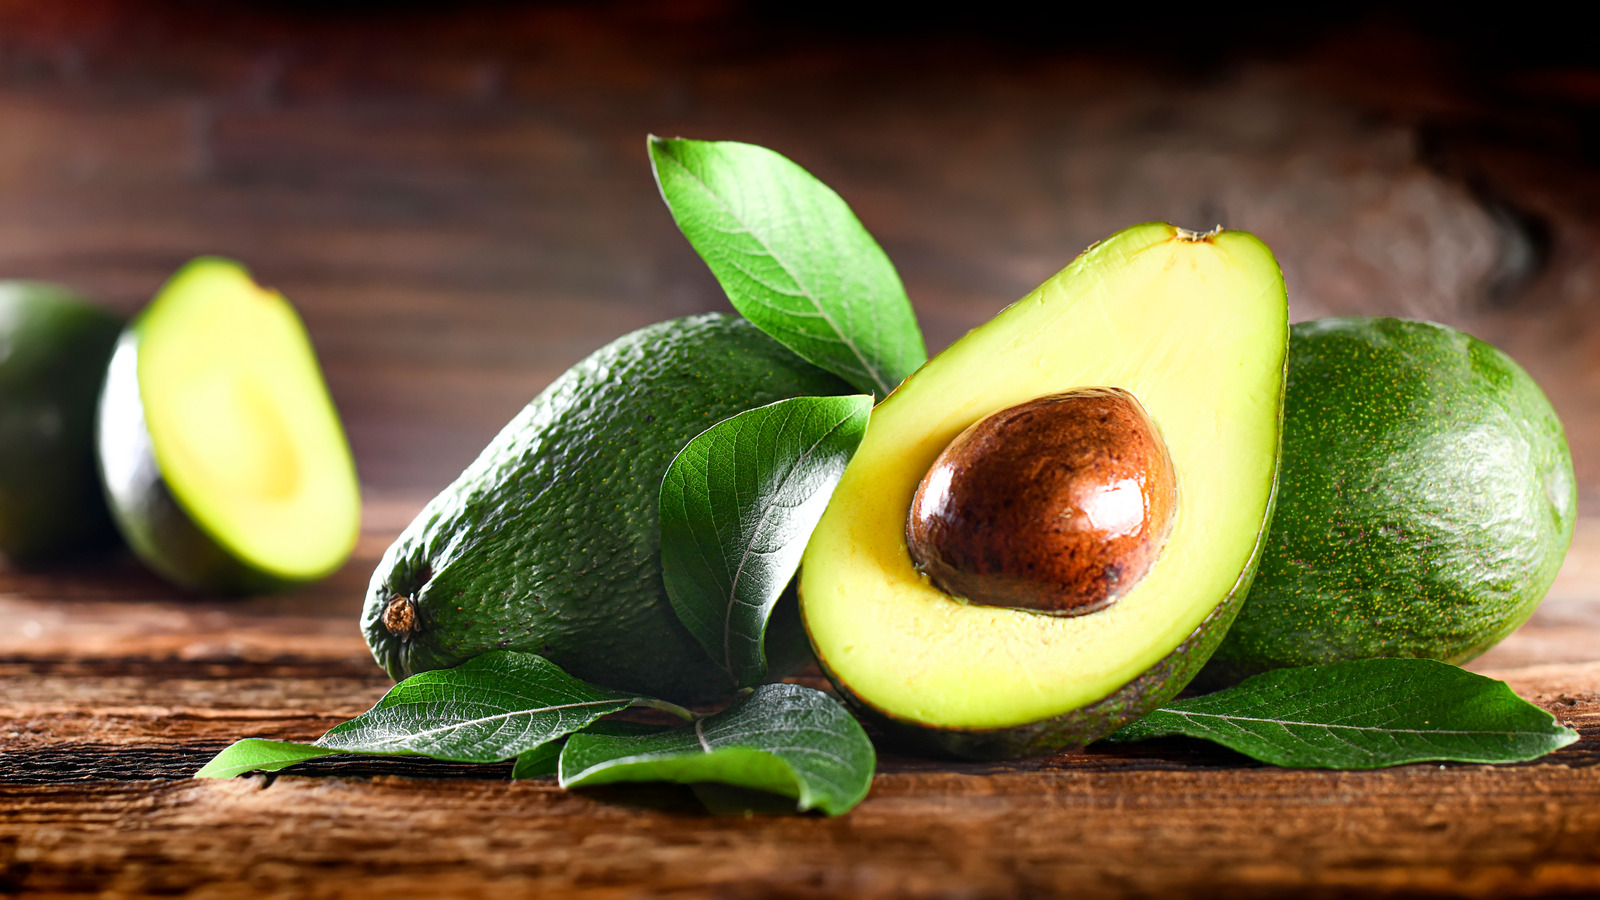

## Need Statement<br>
Dado um determinado conjunto de dados com informações de venda de abacate Hass, eu desejo criar um modelo preditivo capaz de prever o preço médio unitario do abacate Hass.<br><br>
Esses dados foram baixados do site Hass Avocado Board em maio de 2018 e compilados em um único CSV. Veja como o [Hass Avocado Board](https://hassavocadoboard.com/) descreve os dados em seu site:<br><br>
"*Os dados de varredura do varejo vêm diretamente das caixas registradoras dos varejistas com base nas vendas reais no varejo de abacates Hass. O Preço Médio (de abacates) na tabela reflete um custo por unidade (por abacate), mesmo quando várias unidades (abacates) são vendidas em sacos.*"<br><br>

Os dados podem ser acessados mais facilmente atraves da plataforma Kaggle: https://www.kaggle.com/datasets/neuromusic/avocado-prices?resource=download<br><br>

Descrição dos dados: <br><br>

<font color='#e7764e'>Date - </font>A data da observação (semanal);<br>
<font color='#e7764e'>AveragePrice - </font>O preço médio de um único abacate (target);<br>
<font color='#e7764e'>Total Volume - </font>Número total de abacates vendidos;<br>
<font color='#e7764e'>4046 - </font>Número total de abacates com PLU (Product Lookup codes) 4046 vendidos;<br>
<font color='#e7764e'>4225 - </font>Número total de abacates com PLU (Product Lookup codes) 4225 vendidos;<br>
<font color='#e7764e'>4770 - </font>Número total de abacates com  PLU (Product Lookup codes) 4770 vendidos;<br>
<font color='#e7764e'>Total Bags - </font>Total de abacates vendidos em sacos;<br>
<font color='#e7764e'>Small Bags - </font>Número de abacates vendidos em sacos pequenos;<br>
<font color='#e7764e'>Large Bags - </font>Número de abacates vendidos em sacos grandes;<br>
<font color='#e7764e'>XLarge Bags - </font>Número de abacates vendidos em sacos extragrandes;<br>
<font color='#e7764e'>type - </font>Tipo do abacate (convencional ou organico);<br>
<font color='#e7764e'>year - </font>Ano das vendas;<br>
<font color='#e7764e'>region - </font>A cidade ou região da observação.<br>

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from fastai.tabular.core import cont_cat_split

from yellowbrick.regressor import ResidualsPlot, PredictionError

# Import mlflow
from mlflow import log_metric, log_param,log_figure,set_experiment, set_tags, start_run, end_run, set_tracking_uri


from mlflow.sklearn import log_model

## Algumas funções úteis

In [34]:
def basic_info(df:pd.DataFrame)->str:
    s = ""
    count = 1
    for c in df.columns:
        s += f"{count} - {c}\n"
        s += f"    Type: {df[c].dtype}\n"
        s += f"    No. of unique values {df[c].nunique()}\n"
        s += f"    Sample of unique values {df[c].unique()[0:10]}\n"
        s += "\n"
        count += 1
    return s


def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    mdae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, msle, mdae, r2


def register_mlflow(exp_name, model, hyperparams, y_test, y_pred):
    set_experiment(exp_name)
    with start_run(run_name=exp_name):
        mae, mse, msle, mdae, r2 = metrics(y_test, y_pred)

        for p in hyperparams:
            log_param(p, hyperparams[p])

        # metrics
        log_metric("mae", mae)
        log_metric("mse", mse)
        log_metric("msle", msle)
        log_metric("mdae", mdae)
        log_metric("r2", r2)

        # model
        log_model(model, "model")

## Análise Exploratória e Engenharia de Features

Carregando os dados pada um dataframe

In [35]:
df = pd.read_csv('../data/avocado.csv')

Visualizando os 5 primeiros exemplos para termos uma noção de como os dados são, e aqui ja podemos notar uma coluna inutil que contem o id das observações, vamos dropala em seguida

In [36]:
df.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [37]:
df = df.drop('Unnamed: 0', axis=1)

In [38]:
df.head(5)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Visualizando o shape do nosso dataframe

In [39]:
df.shape

(18249, 13)

Visualiando algumas informações basicas sobre os dados, e aqui podemos ver que não existe nenhum valor faltante no dataset, então nenhum tratamento em relação a isso precisara ser feito. O dataframe possui 4 colunas categoricas e 9 colunas continuas. Vamos separalas mais adiante para trabalharmos com elas individualmente.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AveragePrice,18249.0,1.405978,4.026766e-01,0.44,1.10,1.37,1.66,3.25
Total Volume,18249.0,850644.013009,3.453545e+06,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.0,293008.424531,1.264989e+06,0.00,854.07,8645.30,111020.20,22743616.17
4225,18249.0,295154.568356,1.204120e+06,0.00,3008.78,29061.02,150206.86,20470572.61
4770,18249.0,22839.735993,1.074641e+05,0.00,0.00,184.99,6243.42,2546439.11
Total Bags,18249.0,239639.202060,9.862424e+05,0.00,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.0,182194.686696,7.461785e+05,0.00,2849.42,26362.82,83337.67,13384586.80
Large Bags,18249.0,54338.088145,2.439660e+05,0.00,127.47,2647.71,22029.25,5719096.61
XLarge Bags,18249.0,3106.426507,1.769289e+04,0.00,0.00,0.00,132.50,551693.65
year,18249.0,2016.147899,9.399385e-01,2015.00,2015.00,2016.00,2017.00,2018.00


Serapando os dados em categorico e continuos, para uma analise separada de ambos os tipos.

In [42]:
cont_col, cat_col = cont_cat_split(df)
print(f'Continuous Columns: {cont_col}\n')
print(f'Categorical Columns: {cat_col}')

Continuous Columns: ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

Categorical Columns: ['Date', 'type', 'year', 'region']


Visualizando mais algumas informações basicas das varias continuas, como typo dos dados, numero de valores unicos e alguns exemplos de valores unicos. Aqui podemos fazer uma analise sobre a quantidade de abacates vendidos, podemos perceber que a o volume total vendido representa a soma das colunas [4046, 4225, 4770, Total Bags], e por sua vez, a coluna Total Bags representa a soma das colunas [Small Bags, Large Bags, XLarge Bags], vamos dar uma olhada em como esta essa colinearidade.

In [43]:
print(basic_info(df[cont_col]))

1 - AveragePrice
    Type: float64
    No. of unique values 259
    Sample of unique values [1.33 1.35 0.93 1.08 1.28 1.26 0.99 0.98 1.02 1.07]

2 - Total Volume
    Type: float64
    No. of unique values 18237
    Sample of unique values [ 64236.62  54876.98 118220.22  78992.15  51039.6   55979.78  83453.76
 109428.33  99811.42  74338.76]

3 - 4046
    Type: float64
    No. of unique values 17702
    Sample of unique values [1036.74  674.28  794.7  1132.    941.48 1184.27 1368.92  703.75 1022.15
  842.4 ]

4 - 4225
    Type: float64
    No. of unique values 18103
    Sample of unique values [ 54454.85  44638.81 109149.67  71976.41  43838.39  48067.99  73672.72
 101815.36  87315.57  64757.44]

5 - 4770
    Type: float64
    No. of unique values 12071
    Sample of unique values [ 48.16  58.33 130.5   72.58  75.78  43.61  93.26  80.    85.34 113.  ]

6 - Total Bags
    Type: float64
    No. of unique values 18097
    Sample of unique values [ 8696.87  9505.56  8145.35  5811.16  6183.95 

Podemos ver que existe uma forte correlação entre as colunas [4046, 4225, 4770, Total Bags] com a coluna Total Volume, pois a coluna Total Volume representa a soma de todas as outras quatro, apenas a coluna 4770 possui uma correlação um pouco mais fraca, que se deve pelo fato dela ter o menor valor a ser agredado na soma total.

<AxesSubplot: >

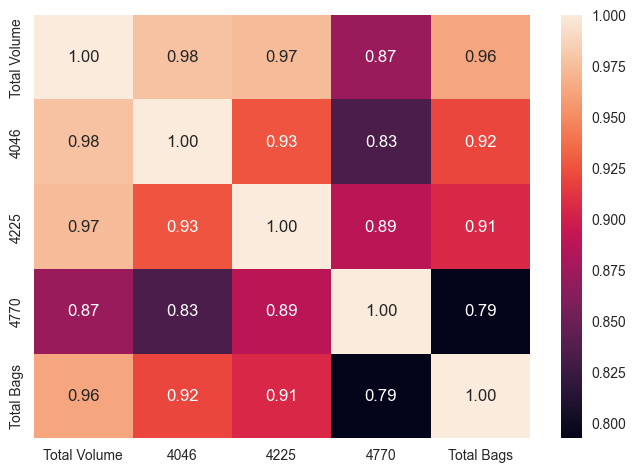

In [44]:
sns.heatmap(abs(df[['Total Volume', '4046', '4225', '4770', 'Total Bags']].corr()), fmt='.2f', annot=True)

Fazendo a mesma coisa para as colunas relacionadas as vendas em sacos, tambem notados a alta correlação entre elas, devido ao fato da coluna Total Bags representar a soma das outras tres, e novamente as colunas Large Bags e XLarge Bags possuem uma correlação mais fraca pois seus valores são menores e agregam menos na soma final.

<AxesSubplot: >

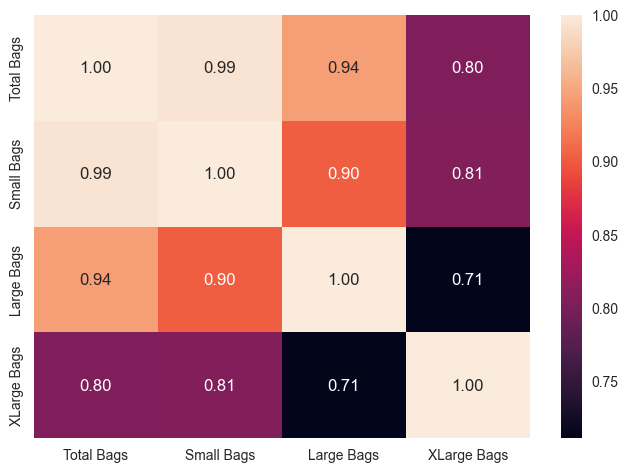

In [45]:
sns.heatmap(abs(df[['Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']].corr()), fmt='.2f', annot=True)

Dropando as features que possuem o valor total da soma das demais features

In [46]:
df = df.drop(columns=['Total Volume', 'Total Bags'], axis=1)

Visualizando mais algumas informações basicas das varias categoricas, como typo dos dados, numero de valores unicos e alguns exemplos de valores unicos. Podemos ver que possui duas colunas representando dadas, uma representado a data semanal em que foi realizada a observação, e outra representando o ano da observação, vamos extrair o dia e o mes da data e transformalos em novas features. Vamos analaisar também a coluna type e region para verificar se os valores estão bem distribuidos ou se existe alguma tendencia.

In [47]:
print(basic_info(df[cat_col]))

1 - Date
    Type: object
    No. of unique values 169
    Sample of unique values ['2015-12-27' '2015-12-20' '2015-12-13' '2015-12-06' '2015-11-29'
 '2015-11-22' '2015-11-15' '2015-11-08' '2015-11-01' '2015-10-25']

2 - type
    Type: object
    No. of unique values 2
    Sample of unique values ['conventional' 'organic']

3 - year
    Type: int64
    No. of unique values 4
    Sample of unique values [2015 2016 2017 2018]

4 - region
    Type: object
    No. of unique values 54
    Sample of unique values ['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton']




Extraindo e transformando o dia e o mes em features

In [48]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [49]:
df.insert(10, 'mounth', df['Date'].dt.strftime('%m'), True)
df.insert(11, 'day', df['Date'].dt.strftime('%d'), True)

Dropando a feature Date pois ja foi expandida para novas features

In [50]:
df = df.drop('Date', axis=1)

Olhando a distribuição entre os dois valores possiveis da coluna type, vemos que os valores estão bem distribuidos, meio a meio, mas vamos ainda converter os nomes conventional e organic para valores binarios, 1 e 0.

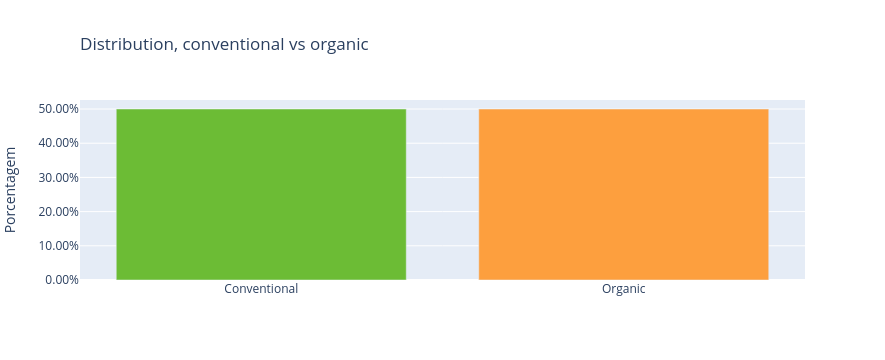

In [51]:
type_perc = dict(df['type'].value_counts(normalize=True))
fig = go.Figure()
fig.add_trace(go.Bar(x=['Conventional', 'Organic'], y=[type_perc['conventional'], type_perc['organic']], 
                     marker=dict(color=['#6cbc35', '#fd9f3e'], colorscale='viridis')))
fig.update_layout(
    title=go.layout.Title(
        text='Distribution, conventional vs organic', xref='paper', x=0
    ),
    yaxis_title='Porcentagem',
    yaxis_tickformat='.2%'
)
fig.show()

Convertendo os valores da feature type para valores numericos binarios, convertional = 1, organic = 0

In [52]:
df['type'] = df['type'].map({'conventional': 1, 'organic': 0})

Visualizando a distribuição das regiões, também podemos notas que as distribuição é bem uniforme, todas regiões aparecem 338 vezes. Porem para que essa feature se torne mais utilizavel precisamos transformas esses valores em colunas, e cada um deles ira receber um valor binario, 1 para caso a observação tenha sido registrado na região, 0 caso contrario. Também podemos observar que algumas regiões representam um aglomerado de regiões, como Northeast, Southeast, TotalUs, West e Midsouth, não queremos esses grupos de regiões poes carregam informações repetidas que ja se encontram nas regiões individuais.

In [53]:
df['region'].value_counts()

Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
C

In [54]:
df = df[~df['region'].isin(['Northeast', 'Southeast', 'TotalUS', 'West', 'Midsouth'])]

Transformando os valores da feature region em novas features com valores numericos

In [55]:
df = pd.concat([df, pd.get_dummies(df['region'])], axis=1)

In [56]:
df.columns

Index(['AveragePrice', '4046', '4225', '4770', 'Small Bags', 'Large Bags',
       'XLarge Bags', 'type', 'year', 'mounth', 'day', 'region', 'Albany',
       'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester',
       'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus',
       'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'GreatLakes',
       'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis',
       'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville',
       'MiamiFtLauderdale', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson',
       'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro',
       'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco',
       'Seattle', 'SouthCarolina', 'SouthCentral', 'Spokane', 'StLouis',
       'Syracuse', 'Tampa', 'WestTexNewMexico'],
      dtype='object')

In [57]:
df = df.drop('region', axis=1)

In [58]:
df = df.rename(columns={'4046': 'PLU4046', '4225': 'PLU4225', '4770': 'PLU4770', 'Small Bags': 'SmallBags', 
                        'Large Bags': 'LargeBags', 'XLarge Bags': 'XLargeBags'}, errors='raise')

In [59]:
df.head(5)

,AveragePrice,PLU4046,PLU4225,PLU4770,SmallBags,LargeBags,XLargeBags,type,year,mounth,...,SanDiego,SanFrancisco,Seattle,SouthCarolina,SouthCentral,Spokane,StLouis,Syracuse,Tampa,WestTexNewMexico
0,1.33,1036.74,54454.85,48.16,8603.62,93.25,0.0,1,2015,12,...,0,0,0,0,0,0,0,0,0,0
1,1.35,674.28,44638.81,58.33,9408.07,97.49,0.0,1,2015,12,...,0,0,0,0,0,0,0,0,0,0
2,0.93,794.70,109149.67,130.50,8042.21,103.14,0.0,1,2015,12,...,0,0,0,0,0,0,0,0,0,0
3,1.08,1132.00,71976.41,72.58,5677.40,133.76,0.0,1,2015,12,...,0,0,0,0,0,0,0,0,0,0
4,1.28,941.48,43838.39,75.78,5986.26,197.69,0.0,1,2015,11,...,0,0,0,0,0,0,0,0,0,0


## Construindo e Treinando o Módelo

Definindo os dados de treino e teste

In [60]:
X = df.drop(columns=['AveragePrice'])    # input
y = df['AveragePrice']    # output

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'-' * 27)
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11591, 59)
y_train shape: (11591,)
---------------------------
X_test shape: (4968, 59)
y_test shape: (4968,)


Fazendo uma busca para encontrar o modelo com o melhor desempenho, tendo o criterio de pontuação o MSE.

In [61]:
pipeline = Pipeline([
    ('rgs', DummyRegressor())
])

grid_values = [
    {
        'rgs': [LinearRegression()]
    },
    {
        'rgs': [BaggingRegressor(base_estimator=RandomForestRegressor())],
    },
    {
        'rgs': [RandomForestRegressor()],
        'rgs__criterion': ['squared_error', 'absolute_error', 'poisson']
    },
    {
        'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor())],
        'rgs__loss': ['linear', 'square', 'exponential']
    },
    {
        'rgs': [GradientBoostingRegressor()],
        'rgs__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'rgs__criterion': ['friedman_mse', 'squared_error']
    },
]

grid_search = GridSearchCV(pipeline, grid_values, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...........rgs=LinearRegression();, score=-0.072 total time=   0.1s
[CV 2/5] END ...........rgs=LinearRegression();, score=-0.067 total time=   0.2s
[CV 3/5] END ...........rgs=LinearRegression();, score=-0.068 total time=   0.1s
[CV 4/5] END ...........rgs=LinearRegression();, score=-0.066 total time=   0.2s
[CV 5/5] END ...........rgs=LinearRegression();, score=-0.069 total time=   0.1s
[CV 1/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.022 total time=  39.0s
[CV 2/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.021 total time=  39.0s
[CV 3/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.022 total time=  38.8s
[CV 4/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.021 total time=  38.3s
[CV 5/5] END rgs=BaggingRegressor(base_estimator=RandomForestRegressor());, score=-0.022 total time=  

GridSearchCV(estimator=Pipeline(steps=[('rgs', DummyRegressor())]),
             param_grid=[{'rgs': [LinearRegression()]},
                         {'rgs': [BaggingRegressor(base_estimator=RandomForestRegressor())]},
                         {'rgs': [RandomForestRegressor()],
                          'rgs__criterion': ['squared_error', 'absolute_error',
                                             'poisson']},
                         {'rgs': [AdaBoostRegressor(base_estimator=RandomForestRegressor())],
                          'rgs__loss': ['linear', 'square', 'exponential']},
                         {'rgs': [GradientBoostingRegressor()],
                          'rgs__criterion': ['friedman_mse', 'squared_error'],
                          'rgs__loss': ['squared_error', 'absolute_error',
                                        'huber', 'quantile']}],
             scoring='neg_mean_squared_error', verbose=3)

Visualizando qual foi o melhor modelo

In [68]:
grid_search.best_estimator_

Pipeline(steps=[('rgs',
                 AdaBoostRegressor(base_estimator=RandomForestRegressor()))])

A pontuação desse melhor modelo

In [63]:
grid_search.best_score_

-0.01609193523448676

Os parametros desse melhor modelo

In [64]:
grid_search.best_params_

{'rgs': AdaBoostRegressor(base_estimator=RandomForestRegressor()),
 'rgs__loss': 'linear'}

In [65]:
model = grid_search.best_estimator_

## Avaliação do Módelo

/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names



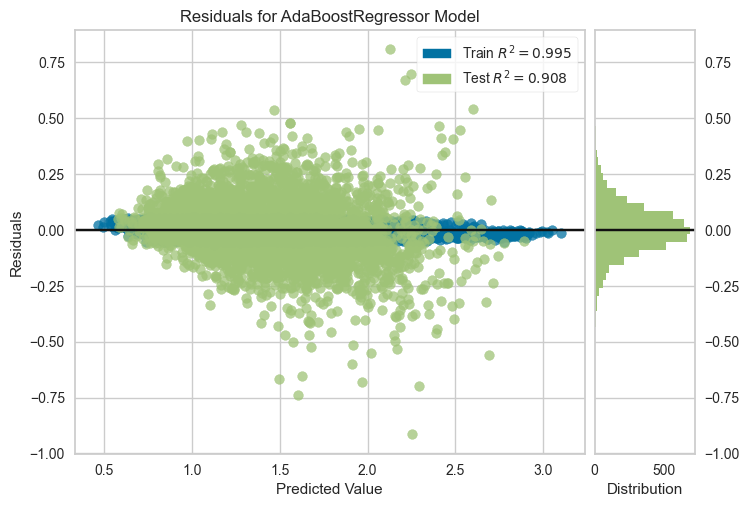

<AxesSubplot: title={'center': 'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [71]:
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names



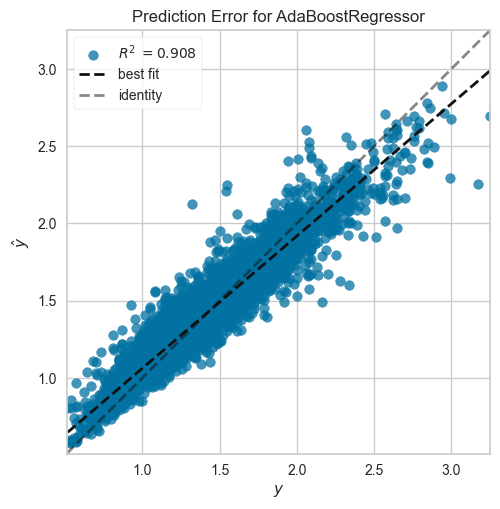

<AxesSubplot: title={'center': 'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [67]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

## Salvando no MLfLow

In [ ]:
y_pred = model.predict(X_test)

register_mlflow(exp_name='Avocado', model=model, hyperparams=grid_search.best_params_, 
                y_test=y_test, y_pred=y_pred)